In [9]:
import os
import glob
import tqdm
import scipy
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, RidgeCV

## 0.) Combine behavioral ratings across 3 datasets

In [11]:
# dataset1
stim_features = pd.read_csv('../control/from_greta/beta-control-neural_stimset_D-S_light_compiled-feats-n=18.csv')
stim_features = stim_features.loc[stim_features.cond=='T']
ratings1 = stim_features['rating_others_thoughts_mean'].values
sentences1 = stim_features.sentence.values
# rescale values to 1-5
norm_ratings1 = [(x - 1) / (7 - 1) for x in ratings1]
ratings1 = [x * (5 - 1) + 1 for x in norm_ratings1]
dataset1 = pd.DataFrame({ 'Sentence' : sentences1, 'SocialRating' : ratings1 , 'Dataset' : ['control']*sentences1.shape[0] })
dataset1.head()

,Sentence,SocialRating,Dataset
0,Taste that fowl and those fish.,2.481481,control
1,All sorts of treasure there too.,2.087719,control
2,The small flock of birds circled.,1.714286,control
3,The music drums inside my head.,3.523810,control
4,They are very devoted and faithful.,3.750000,control


In [25]:
files = glob.glob('../control/from_greta/filtered_data/*filtered_SD-2.csv')
for file in files:
    ratings1_curr = pd.read_csv(files[0])
    print(ratings1_curr.loc[ratings1_curr.cond=='T'].groupby('sentence').rating_others_thoughts.count().unique())

[18]
[18]
[18]
[18]
[18]
[18]
[18]
[18]
[18]
[18]
[18]
[18]
[18]
[18]
[18]
[18]
[18]
[18]
[18]
[18]


In [4]:
# dataset2
ratings2 = pd.read_csv('../experiments/PereiraRevision/behavioral/ID_df.csv', index_col=0)
sentences2 = pd.read_csv('../experiments/PereiraRevision/behavioral/cerebellum_sentence_norming_key.csv')
ratings2_agg = []
count2_agg = []
for idx, row in sentences2.iterrows():
    ratings2_agg.append(ratings2.loc[ratings2.Sentence==row.Code].Rating.mean())
    count2_agg.append(ratings2.loc[ratings2.Sentence==row.Code].Rating.count())
dataset2 = pd.DataFrame({ 'Sentence' : sentences2.Sentence.values, 'SocialRating' : ratings2_agg , 'nRaters' : count2_agg, 'Dataset' : ['pereira']*sentences2.shape[0] })
dataset2.head()

,Sentence,SocialRating,nRaters,Dataset
0,A refrigerator is a cooling device used to con...,1.531250,32,pereira
1,Some refrigerators can have a small compartmen...,1.593750,32,pereira
2,It can have shelves and small compartments for...,1.750000,32,pereira
3,It is generally white and people often put mag...,2.375000,32,pereira
4,A blender is a kitchen appliance used to mix i...,1.482759,29,pereira


In [5]:
dataset2.nRaters.unique()

array([32, 29, 31, 30, 28])

In [7]:
# dataset 3
ratings3 = pd.read_csv('../experiments/langloc/by_block/LangLocSet1_SentenceNorming_updated.csv',index_col=0)
ratings3 = ratings3.iloc[:,4:].values.mean(axis=0)[:-1]
count3 = pd.read_csv('../experiments/langloc/by_block/LangLocSet1_SentenceNorming_updated.csv',index_col=0)
count3 = count3.iloc[:,4:].count(axis=0).values[:-1]
sentences3 = pd.read_csv('../experiments/langloc/by_block/LangLocSet1_sentences.csv',index_col=0).sentence.values[:-1].tolist()
dataset3 = pd.DataFrame({ 'Sentence' : sentences3, 'SocialRating' : ratings3 , 'nRaters' : count3 , 'Dataset' : ['langloc']*len(sentences3) })
dataset3.head()

,Sentence,SocialRating,nRaters,Dataset
0,Just the barest suggestion of a heel is found ...,2.170732,41,langloc
1,"To the directors, the problem appeared a matte...",3.512195,41,langloc
2,There was little likelihood of any customers w...,2.756098,41,langloc
3,He stopped pacing to stare at Hal with his pal...,3.756098,41,langloc
4,A number of considerations suggest that this o...,2.317073,41,langloc


In [13]:
dataset3.nRaters.unique()

array([41])

In [16]:
# ---- COMBINE DATASETS ----
ratings = pd.concat([dataset1, dataset2, dataset3], axis=0)
ratings.to_csv('stimuli_w_ratings.csv', index=False)

ratings_for_gretas_code = pd.DataFrame()
ratings_for_gretas_code['sentence'] = ratings.Sentence.values
ratings_for_gretas_code.index = ['stimid.'+str(int(i+1)) for i in ratings_for_gretas_code.index]
ratings_for_gretas_code.index.name = 'stimid'
ratings_for_gretas_code.to_csv('stimuli.csv', index=True)

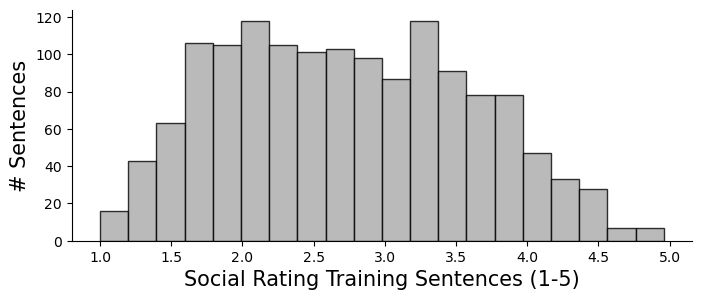

In [3]:
# view distribution of social ratings for training sentences
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
plt.rc('font',**{'family':'sans-serif'})
plt.rc('pdf', **{'fonttype':42})
fig,ax = plt.subplots(figsize=(8,3))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ratings = pd.read_csv('ratings/stimuli_w_ratings.csv')
style1 = {'facecolor': 'darkgrey', 'alpha': 0.8, 'edgecolor': 'black', 'linewidth': 1}
plt.hist(ratings.SocialRating, bins=20, **style1)
ax.set_xlabel('Social Rating Training Sentences (1-5)',fontsize=15)
ax.set_ylabel('# Sentences',fontsize=15)

plt.savefig('ratings/social_ratings_distribution_training.pdf',format='pdf',bbox_inches='tight',pad_inches=0.5)
plt.savefig('ratings/social_ratings_distribution_training.png',format='png',bbox_inches='tight',pad_inches=0.5)

## 0.1) Test split-half reliability by dataset

In [10]:
# dataset1
iters = 1000
files = glob.glob('../control/from_greta/filtered_data/*filtered_SD-2.csv')
corrs = np.zeros((iters,len(files)))
np.random.seed(123)
for f, file in enumerate(files):
    ratings1_curr = pd.read_csv(files[0])
    ratings1_curr = ratings1_curr.loc[ratings1_curr.cond=='T']
    subs = ratings1_curr.subject_id.unique()
    for itr in tqdm.tqdm(range(iters)):
        subs_perm = np.random.permutation(subs)
        set1 = ratings1_curr.loc[[sub in subs_perm[:int(len(subs)/2)] for sub in ratings1_curr.subject_id]]
        set2 = ratings1_curr.loc[[sub in subs_perm[int(len(subs)/2):] for sub in ratings1_curr.subject_id]]
        set1_means = set1.groupby('sentence').rating_others_thoughts.mean()
        set2_means = set2.groupby('sentence').rating_others_thoughts.mean()
        corrs[itr,f] = scipy.stats.pearsonr(set1_means,set2_means).statistic

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.11it/s]


In [14]:
output = pd.DataFrame(corrs, columns=['list'+str(int(i+1)) for i in range(len(files))], index=['iter'+str(int(i+1)) for i in range(iters)])
output.to_csv('ratings/ratings_dataset1_control_splithalf_reliability.csv', index=True)

In [16]:
for f in range(len(files)):
    print(f'List {f}, mean = {round(np.mean(corrs[:,f],axis=0),3)}, std = {round(np.std(corrs[:,f],axis=0),3)}')
print(f'-----\nmean over all lists = {round(np.mean(np.mean(corrs,axis=0),axis=0),3)}, std over all lists = {round(np.std(np.mean(corrs,axis=0),axis=0),3)}')

List 0, mean = 0.837, std = 0.049
List 1, mean = 0.84, std = 0.044
List 2, mean = 0.837, std = 0.048
List 3, mean = 0.843, std = 0.043
List 4, mean = 0.839, std = 0.045
List 5, mean = 0.839, std = 0.044
List 6, mean = 0.839, std = 0.047
List 7, mean = 0.842, std = 0.044
List 8, mean = 0.839, std = 0.046
List 9, mean = 0.841, std = 0.047
List 10, mean = 0.84, std = 0.045
List 11, mean = 0.84, std = 0.046
List 12, mean = 0.842, std = 0.045
List 13, mean = 0.837, std = 0.049
List 14, mean = 0.84, std = 0.049
List 15, mean = 0.84, std = 0.047
List 16, mean = 0.844, std = 0.043
List 17, mean = 0.839, std = 0.046
List 18, mean = 0.84, std = 0.046
List 19, mean = 0.837, std = 0.047
-----
mean over all lists = 0.84, std over all lists = 0.002


In [46]:
# dataset2 (not ideal for split half reliability because paraticipants saw different sets of items and different number of ratings were collected per item)
ratings2 = pd.read_csv('../experiments/PereiraRevision/behavioral/ID_df.csv', index_col=0)
ratings2_agg = np.zeros((len(ratings2.Sentence.unique()),32)) # sent x rater (max number could be less)
items = []
for s, sent in enumerate(ratings2.Sentence.unique()):
    ratings2_curr = ratings2.loc[ratings2.Sentence==sent].Rating.values
    if len(ratings2_curr)!=32:
        ratings2_curr = np.concatenate((ratings2_curr,np.zeros((32-len(ratings2_curr),))))
    ratings2_agg[s,:] = ratings2_curr
ratings2_agg[ratings2_agg == 0] = np.nan

# random samples
iters = 1000
subs = np.arange(0,32)
corrs = np.zeros((iters,1))
np.random.seed(123)
for itr in tqdm.tqdm(range(iters)):
    subs_perm = np.random.permutation(subs)
    set1 = ratings2_agg[:,subs_perm[:int(len(subs)/2)]]
    set2 = ratings2_agg[:,subs_perm[int(len(subs)/2):]]
    set1_means = np.nanmean(set1, axis=1)
    set2_means = np.nanmean(set2, axis=1)
    corrs[itr,0] = scipy.stats.pearsonr(set1_means,set2_means).statistic

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3026.39it/s]


In [47]:
print(f'mean = {round(np.mean(corrs[:,0],axis=0),3)}, std = {round(np.std(corrs[:,0],axis=0),3)}')

mean = 0.782, std = 0.022


In [68]:
# dataset 3
ratings3 = pd.read_csv('../experiments/langloc/by_block/LangLocSet1_SentenceNorming_updated.csv',index_col=0)
ratings3 = ratings3.iloc[:,4:-1].values.T # sent x raters

iters = 1000
subs = np.arange(0,ratings3.shape[1])
corrs = np.zeros((iters,1))
np.random.seed(123)
for itr in tqdm.tqdm(range(iters)):
    subs_perm = np.random.permutation(subs)
    set1 = ratings3[:,subs_perm[:int(len(subs)/2)]]
    set2 = ratings3[:,subs_perm[int(len(subs)/2):]]
    set1_means = np.nanmean(set1, axis=1)
    set2_means = np.nanmean(set2, axis=1)
    corrs[itr,0] = scipy.stats.pearsonr(set1_means,set2_means).statistic

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3582.13it/s]


In [70]:
print(f'mean = {round(np.mean(corrs[:,0],axis=0),3)}, std = {round(np.std(corrs[:,0],axis=0),3)}')

mean = 0.908, std = 0.025


## 1.) Extract GPT2-xl embeddings 

In [2]:
# extract GPT2-xl embeddings for sentences with social ratings
os.chdir('code/drive_suppress_brains-colton/src/run_analyses')
!pwd
os.system(' '.join(["python cache_ANN_encodings.py",
                    "--input_file ../../../../stimuli.csv",
                    "--source_model gpt2-xl",
                    "--sent_emb last-tok",
                    "--actv_cache_setting auto",
                    "--actv_cache_path /nese/mit/group/evlab/u/ccasto/projects/cerebellum/social/cache"]))
os.chdir('../../../../')

/nese/mit/group/evlab/u/ccasto/projects/cerebellum/social/code/drive_suppress_brains-colton/src/run_analyses


100%|██████████| 1432/1432 [21:07<00:00,  1.13it/s]


Number of stimuli in activations: 1432
Number of units in activations: 78400


Caching newly computed activations!
Cached activations to /nese/mit/group/evlab/u/ccasto/projects/cerebellum/social/cache/stimid_actv.pkl


## 2.) Fit encoding model
* Find best layer
    * 5-fold cross validation (holding out 1/5 sentences)
    * Ridge regression (leave-one-out cross validation on sentences in training set to get alpha per fold)
* Find best alpha
    * Leave-one-out cross validation on all sentences
* Train full encoding model and save weights

In [43]:
# --- EVALUTATE PERFORMANCE BY LAYER ---
# load model embeddings
with open('cache/stimid_actv.pkl','rb') as f:
    activations = pickle.load(f)

# load social ratings
ratings = pd.read_csv('stimuli_w_ratings.csv')
y = ratings.SocialRating.values

# initialize RidgeCV model
alphas = [10 ** x for x in range(-30, 30)]
clf = RidgeCV(alphas, alpha_per_target=True) # only one target because behavioral

# initialize KFold splitter
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# look at performance for each layer
scores = np.zeros((5,49))
for l in tqdm.tqdm(range(0,49)):
    X = activations.loc[:,l].values
    
    # cross validation!
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
    
        y_pred = clf.predict(X_test)
        scores[fold_idx,l] = scipy.stats.pearsonr(y_test, y_pred)[0]

scores = pd.DataFrame(scores, columns=[f'layer.{int(l)}' for l in range(0,49)], index=[f'fold{f}' for f in range(1,6)])
scores.to_csv('encoding_performance_by_layer_training_stimuli.csv')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [02:00<00:00,  2.46s/it]



Best performing layer: **** layer.27 (r=0.8702526584122918) ****



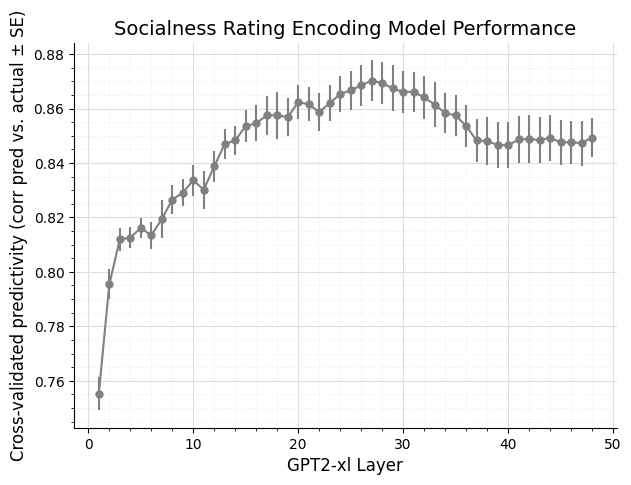

In [48]:
# --- PLOT PERFORMANCE BY LAYER ---
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
plt.rc('font',**{'family':'sans-serif'})
plt.rc('pdf', **{'fonttype':42})
fig,ax = plt.subplots(figsize=(7,5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

scores = pd.read_csv('encoding_performance_by_layer_training_stimuli.csv', index_col=[0])

print(f'\nBest performing layer: **** {scores.columns[np.argmax(scores.mean(axis=0).values)]} (r={np.max(scores.mean(axis=0).values)}) ****\n')

layers = scores.shape[1]
plt.errorbar(np.arange(1,layers), scores.mean(axis=0).values[1:], yerr=scores.std(axis=0).values[1:]/np.sqrt(scores.shape[0]), color='gray', marker='.', markersize=10)
plt.grid(True)
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.minorticks_on()
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.8)
plt.xlabel('GPT2-xl Layer', fontsize=12)
plt.ylabel('Cross-validated predictivity (corr pred vs. actual ± SE)', fontsize=12)
plt.title('Socialness Rating Encoding Model Performance', fontsize=14)

plt.savefig('encoding_performance_by_layer_training_stimuli.png',format='png',bbox_inches='tight',pad_inches=0.5) 
plt.savefig('encoding_performance_by_layer_training_stimuli.pdf',format='pdf',bbox_inches='tight',pad_inches=0.5) 

In [47]:
# --- FIND OPTIMAL ALPHA (ON ALL SENTENCES LEAVE-ONE-OUT) ---
# load model embeddings
with open('cache/stimid_actv.pkl','rb') as f:
    activations = pickle.load(f)
X = activations.loc[:,27].values # layer from above

# load social ratings
ratings = pd.read_csv('stimuli_w_ratings.csv')
y = ratings.SocialRating.values

# initialize RidgeCV model
alphas = [10 ** x for x in range(-30, 30)]
clf = RidgeCV(alphas, alpha_per_target=True) # only one target because behavioral

clf.fit(X, y)
    
print(f'\nBest alpha: **** {clf.alpha_} ****\n')


Best alpha: **** 10000 ****



In [58]:
# --- FIT FINAL ENCODING MODEL ---
# load model embeddings
with open('cache/stimid_actv.pkl','rb') as f:
    activations = pickle.load(f)
X = activations.loc[:,27].values # layer from above

# load social ratings
ratings = pd.read_csv('ratings/stimuli_w_ratings.csv')
y = ratings.SocialRating.values

# initialize Ridge model
clf = Ridge(alpha=10000) # alpha from above

clf.fit(X, y)

# save encoding model weights
np.save('encoding_model_weights_training_stimuli.npy', clf.coef_)

## 3.) Find maximally/minimally social sentences

In [19]:
# --- IDENTIFY AND AGGREGATE 12-WORD SENTENCES FROM CORPORA ---
# formatting corpora to run with Greta's embedding extraction code
CORPORA_PATH = '/om2/group/evlab/parse-corpora'
dirs = [
    'brown',
    'cocaspok',
    'cocaspok',
    'cocaspok',
    'cocaspok',
    'ud',
    'wsj'
]
files = [
    'brown',
    'cocaspok2009',
    'cocaspok2010',
    'cocaspok2011',
    'cocaspok2012',
    'ud',
    'wsj'
]
for dir, file in zip(dirs,files):
    with open(os.path.join(CORPORA_PATH,dir,file+'_stimuli.pkl'),'rb') as f:
        corp = pickle.load(f)
    corp['length'] = corp.sentence.apply(lambda x: len(x.split(' ')))
    corp = corp.loc[corp.length==12].reset_index()
    
    for_gretas_code = pd.DataFrame()
    for_gretas_code['sentence'] = corp.sentence.values
    for_gretas_code.index = ['stimid.'+str(int(i+1)) for i in for_gretas_code.index]
    for_gretas_code.index.name = 'stimid'
    for_gretas_code.to_csv('stimuli_'+file+'.csv', index=True)

In [20]:
# example function call (not used!)
# corp = 'cocaspok2012'
# os.chdir('code/drive_suppress_brains-colton/src/run_analyses')
# !pwd
# os.system(' '.join(["python cache_ANN_encodings.py",
#                     f"--input_file ../../../../stimuli_{corp}.csv",
#                     "--source_model gpt2-xl",
#                     "--sent_emb last-tok",
#                     "--actv_cache_setting auto",
#                     f"--actv_cache_path /nese/mit/group/evlab/u/ccasto/projects/cerebellum/social/cache/{corp}"]))
# os.chdir('../../../../')

In [21]:
# extract GPT2-xl embeddings for sentences (done in batch jobs!)

In [59]:
# --- FIND MOST/LEAST SOCIAL SENTENCES ---
# assumes clf variable in memory, re-run block above if not
corpora = [
    'brown',
    'cocaspok2009',
    'cocaspok2010',
    'cocaspok2011',
    'cocaspok2012',
    'ud',
    'wsj'
]
for corp in corpora:
    stim = pd.read_csv(f'stimuli/stimuli_{corp}.csv', index_col=0)
    
    with open(f'cache/{corp}/stimid_actv.pkl','rb') as f:
        activations = pickle.load(f)
    X = activations.loc[:,27].values # layer from above
    
    stim['PredictedSocialRating'] = clf.predict(X)
    stim.to_csv(f'ratings/stimuli_{corp}_w_predicted_ratings.csv')
    print(f'Finished {corp}')

Finished brown
Finished cocaspok2009
Finished cocaspok2010
Finished cocaspok2011
Finished cocaspok2012
Finished ud
Finished wsj


In [3]:
# --- FIND SUBSET OF MOST/LEAST SOCIAL SENTENCES TO USE ---
corpora = [
    'brown',
    'cocaspok2009',
    'cocaspok2010',
    'cocaspok2011',
    'cocaspok2012',
    'ud',
    'wsj'
]
ratings = pd.DataFrame()
for corp in corpora:
    curr = pd.read_csv(f'ratings/stimuli_{corp}_w_predicted_ratings.csv')
    curr_surp = pd.read_csv(f'surprisal/stimuli_{corp}_w_suprisal.csv')
    curr['corpus'] = [corp]*curr.shape[0]
    curr['SurprisalAverage'] = curr_surp.surprisal_avg.values
    curr['SurprisalLastTok'] = curr_surp.surprisal_lasttok.values
    ratings = pd.concat([ratings,curr])
# preprocess
ratings = ratings.drop_duplicates(subset=['sentence'], keep='first') # duplicates
to_keep = []
for sent in ratings.sentence: 
    digit = any(char.isdigit() for char in sent) # has digit in it
    upper = np.sum([char.isupper() for char in sent]) > 1 # has > 1 uppercase character
    symb = any(char in ['$','%','#','@','!','^','&','*','(',')','{','[','}',']','/','|'] for char in sent) # has symbol in it
    to_keep.append(~(digit | upper | symb))
ratings = ratings.loc[to_keep]
ratings

,stimid,sentence,PredictedSocialRating,corpus,SurprisalAverage,SurprisalLastTok
0,stimid.1,"Each day the hurt was a little duller, a littl...",4.107893,brown,4.085186,6.758869
1,stimid.2,"She lay there, making no effort to get back on...",3.978630,brown,3.059282,0.079224
2,stimid.3,He didn't think it was possible for this coupl...,4.176861,brown,3.588933,10.723232
4,stimid.5,He caught her by an arm and helped her into th...,3.684889,brown,3.488148,4.345854
5,stimid.6,He told himself he had never seen two people e...,4.001499,brown,3.993334,1.000481
...,...,...,...,...,...,...
16010,stimid.16011,Those drops indicate there is little inflation...,2.595163,wsj,4.860460,0.975912
16011,stimid.16012,"But, given widespread counterfeiting, he worri...",2.278315,wsj,5.251684,9.550590
16014,stimid.16015,That's probably low; the same estimate was alr...,2.313363,wsj,4.627087,1.076897
16017,stimid.16018,"""The parts were greater than the sum of the wh...",3.529580,wsj,4.124188,11.054189


In [4]:
print('Composition of corpora:\n-----------------------')
for corp in corpora:
    curr = ratings.loc[ratings.corpus==corp]
    print(f'{corp} = {curr.shape[0]} ({round((curr.shape[0]/ratings.shape[0])*100,2)}%)')

Composition of corpora:
-----------------------
brown = 1127 (5.31%)
cocaspok2009 = 3896 (18.35%)
cocaspok2010 = 4060 (19.12%)
cocaspok2011 = 4031 (18.99%)
cocaspok2012 = 2241 (10.56%)
ud = 465 (2.19%)
wsj = 5410 (25.48%)


High threshold: 4.109737631908796 (531 sentences)
Low threshold: 1.9742861727874907 (531 sentences)


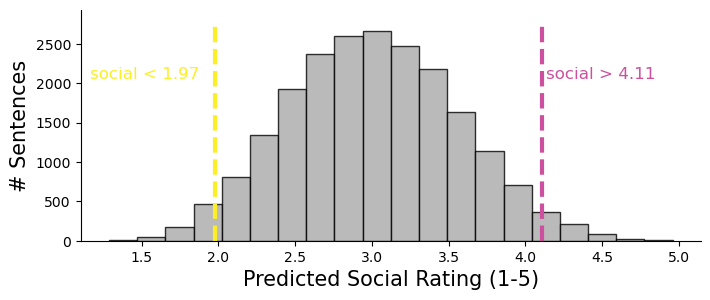

In [5]:
# view distribution of predicted social ratings
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
plt.rc('font',**{'family':'sans-serif'})
plt.rc('pdf', **{'fonttype':42})
fig,ax = plt.subplots(figsize=(8,3))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

style1 = {'facecolor': 'darkgrey', 'alpha': 0.8, 'edgecolor': 'black', 'linewidth': 1}
plt.hist(ratings.PredictedSocialRating, bins=20, **style1)
ax.set_xlabel('Predicted Social Rating (1-5)',fontsize=15)
ax.set_ylabel('# Sentences',fontsize=15)

high_thresh = np.percentile(ratings.PredictedSocialRating,97.5)
low_thresh = np.percentile(ratings.PredictedSocialRating,2.5)
print(f'High threshold: {high_thresh} ({ratings.loc[ratings.PredictedSocialRating>high_thresh].shape[0]} sentences)')
print(f'Low threshold: {low_thresh} ({ratings.loc[ratings.PredictedSocialRating<low_thresh].shape[0]} sentences)')

ylims = ax.get_ylim()
ax.vlines(high_thresh,ylims[0],ylims[1],colors='#CC509D',linestyles='dashed',linewidth=3)
ax.vlines(low_thresh,ylims[0],ylims[1],colors='#FCEE27',linestyles='dashed',linewidth=3)
ax.annotate('social > '+str(round(high_thresh,2)),(0.75,0.7),fontsize=12,color='#CC509D',xycoords='axes fraction')
ax.annotate('social < '+str(round(low_thresh,2)),(0.015,0.7),fontsize=12,color='#FCEE27',xycoords='axes fraction')
plt.savefig('ratings/predicted_social_ratings_distribution.pdf',format='pdf',bbox_inches='tight',pad_inches=0.5)
plt.savefig('ratings/predicted_social_ratings_distribution.png',format='png',bbox_inches='tight',pad_inches=0.5)

In [6]:
# algorithm for selecting stimuli: 
# - restrict to top/bottom 5%
# - randomly sample item from high social sentences
# - find low social sentence that is matched for surprisal

high_thresh = np.percentile(ratings.PredictedSocialRating,95)
high_sents = ratings.loc[ratings.PredictedSocialRating>high_thresh]
low_thresh = np.percentile(ratings.PredictedSocialRating,5)
low_sents = ratings.loc[ratings.PredictedSocialRating<low_thresh]

random.seed(123)
items_desired = 60
high_sents_use = pd.DataFrame()
low_sents_use = pd.DataFrame()
for i in range(0,items_desired):
    # --- RANDOMLY SELECT HIGH SOCIAL SENTENCE ---
    curr_high = random.choice(high_sents.sentence.values)
    # make sure not already selected
    if not high_sents_use.empty:
        while curr_high in high_sents_use.sentence.values.tolist():
            curr_high = random.choice(high_sents.sentence.values)
    high_sents_use = pd.concat([high_sents_use,high_sents.loc[high_sents.sentence==curr_high]])

    # --- SELECT LOW SOCIAL SENTENCE THAT IS MATCHED FOR SUPRISAL ---
    surp_diff = np.abs(low_sents.SurprisalAverage - high_sents_use.SurprisalAverage.values[-1]).tolist()
    surp_diff_sorted = sorted(surp_diff)
    curr_low = low_sents.sentence.values[surp_diff.index(surp_diff_sorted[0])]
    if not low_sents_use.empty:
        arg = 1
        while curr_low in low_sents_use.sentence.values.tolist():
            curr_low = low_sents.sentence.values[surp_diff.index(surp_diff_sorted[arg])]
            arg += 1
    low_sents_use = pd.concat([low_sents_use,low_sents.loc[low_sents.sentence==curr_low]])
high_sents_use.to_csv('stimuli_high_social_sentences.csv',index=False)
low_sents_use.to_csv('stimuli_low_social_sentences.csv',index=False)

In [7]:
high_sents_use

,stimid,sentence,PredictedSocialRating,corpus,SurprisalAverage,SurprisalLastTok
955,stimid.956,We realized -- for the first time how fragile ...,4.172620,cocaspok2009,4.634818,2.108653
98,stimid.99,A lot of us have not raised kids that act that...,3.985171,cocaspok2011,3.968811,0.061017
3121,stimid.3122,I just wanted to know that he was being taken ...,4.349184,cocaspok2009,3.132295,0.015691
537,stimid.538,I didn't have all my treatments because it was...,4.137927,cocaspok2012,4.237555,0.123439
65,stimid.66,You say your dad was easy to love but hard to ...,4.095061,cocaspok2011,4.366307,6.072331
5074,stimid.5075,Your wife famously talked about the vast right...,4.184542,cocaspok2009,5.212061,3.877909
1870,stimid.1871,"He was wide awake, but he did not feel like do...",4.283035,brown,2.961629,0.538334
7152,stimid.7153,She could -- could get no zest from the though...,4.403136,cocaspok2011,5.572079,8.063478
4187,stimid.4188,"What is she thinking, you know, she had to hav...",4.082223,cocaspok2011,3.948681,2.200169
4694,stimid.4695,Have you noticed the sheer hatred of the guy f...,4.103111,cocaspok2011,4.093943,1.896575


In [8]:
print('Composition of corpora (HIGHLY SOCIAL SENTENCES):\n-------------------------------------------------')
for corp in corpora:
    curr = high_sents_use.loc[high_sents_use.corpus==corp]
    print(f'{corp} = {curr.shape[0]} ({round((curr.shape[0]/high_sents_use.shape[0])*100,2)}%)')

Composition of corpora (HIGHLY SOCIAL SENTENCES):
-------------------------------------------------
brown = 7 (11.67%)
cocaspok2009 = 13 (21.67%)
cocaspok2010 = 8 (13.33%)
cocaspok2011 = 18 (30.0%)
cocaspok2012 = 7 (11.67%)
ud = 1 (1.67%)
wsj = 6 (10.0%)


In [9]:
low_sents_use

,stimid,sentence,PredictedSocialRating,corpus,SurprisalAverage,SurprisalLastTok
5006,stimid.5007,"For the most part, it closely tracks with broa...",1.963962,wsj,4.632927,7.883695
6947,stimid.6948,The same holds true for the immigration cases ...,1.852269,cocaspok2011,3.970482,0.694749
838,stimid.839,In a few days the snake will begin to shed its...,2.072972,ud,3.132306,0.276652
3919,stimid.3920,Most financial terms in the text are linked to...,1.914807,wsj,4.240518,0.022039
1429,stimid.1430,"Besides, the number of the suite hasn't been p...",1.904298,brown,4.366123,5.737756
482,stimid.483,The piping would lead down into your sump from...,1.676094,ud,5.215560,4.355867
13620,stimid.13621,The agency is in the process of issuing subpoe...,2.077613,wsj,2.956002,2.238444
8389,stimid.8390,Now agricultural sales benefits will be reaped...,1.836158,wsj,5.570576,6.761487
919,stimid.920,"If they are not ellipsoids, the conclusions wi...",2.105906,brown,3.948659,1.947184
10721,stimid.10722,Its next generation of products will probably ...,1.986067,wsj,4.091665,3.691477


In [11]:
print('Composition of corpora (LOW SOCIAL SENTENCES):\n----------------------------------------------')
for corp in corpora:
    curr = low_sents_use.loc[low_sents_use.corpus==corp]
    print(f'{corp} = {curr.shape[0]} ({round((curr.shape[0]/low_sents_use.shape[0])*100,2)}%)')

Composition of corpora (LOW SOCIAL SENTENCES):
----------------------------------------------
brown = 7 (11.67%)
cocaspok2009 = 6 (10.0%)
cocaspok2010 = 9 (15.0%)
cocaspok2011 = 6 (10.0%)
cocaspok2012 = 1 (1.67%)
ud = 3 (5.0%)
wsj = 28 (46.67%)


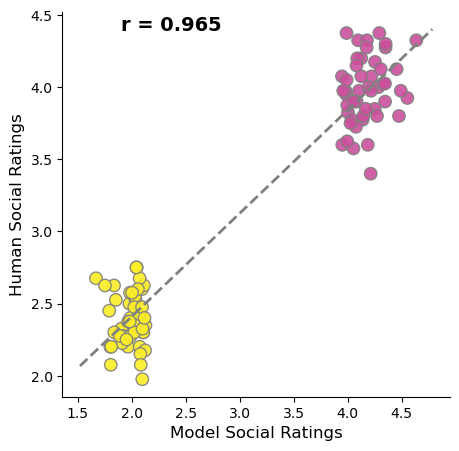

In [24]:
# compare model predictions to human ratings for final 48 items
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
plt.rc('font',**{'family':'sans-serif'})
plt.rc('pdf', **{'fonttype':42})
fig,ax = plt.subplots(figsize=(5,5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

model_ratings1 = pd.read_csv('stimuli_high_social_sentences_USE.csv').PredictedSocialRating
model_ratings2 = pd.read_csv('stimuli_low_social_sentences_USE.csv').PredictedSocialRating
model_ratings = pd.concat([model_ratings1, model_ratings2], axis=0).values
x = model_ratings

human_ratings = pd.read_csv('SocialSentences_SentenceNorming_updated.csv',index_col=0)
human_ratings = human_ratings.iloc[:,4:].mean(axis=0).values
y = human_ratings

colors = ['#CC509D']*48+['#FCEE27']*48

ax.scatter(x,y,s=80,c=colors,edgecolor='grey',alpha=0.9,zorder=1)
                            
# dashed fit line
slope, intercept, r, p, _ = scipy.stats.linregress(x,y)
f = lambda a : slope*a + intercept
xlim = ax.get_xlim()
xvals = np.arange(xlim[0],xlim[1],0.001)    
yvals = f(xvals)
ax.plot(xvals,yvals,'--',color='grey',linewidth=2,zorder=2)
    
sig_label1 = 'r = ' + str(round(r,3))
ax.annotate(text=sig_label1, xy =(0.15,0.95), xycoords='axes fraction', fontsize=14, weight="heavy")
    
ax.set_xlabel('Model Social Ratings',fontsize=12)
ax.set_ylabel('Human Social Ratings',fontsize=12)
    
# save
plt.savefig(f'SocialSentences_SentenceNorming_vs_model_predictions.pdf',format='pdf',bbox_inches='tight',pad_inches=0.5) 
plt.savefig(f'SocialSentences_SentenceNorming_vs_model_predictions.png',format='png',bbox_inches='tight',pad_inches=0.5) 

In [7]:
# check suprisal
stim1 = pd.read_csv('stimuli_high_social_sentences_USE.csv').SurprisalAverage.values
stim2 = pd.read_csv('stimuli_low_social_sentences_USE.csv').SurprisalAverage.values
print(f'High social: {np.mean(stim1)}\nLow Social: {np.mean(stim2)}')
print(f'p = {scipy.stats.mannwhitneyu(stim1,stim2).pvalue} (Mann-Whitney U test')

High social: 3.858799685376745
Low Social: 3.8408703316393242
p = 0.8690449913786669 (Mann-Whitney U test


In [3]:
model_ratings1 = pd.read_csv('stimuli_high_social_sentences_USE.csv')
model_ratings2 = pd.read_csv('stimuli_low_social_sentences_USE.csv')
model_ratings = pd.concat([model_ratings1, model_ratings2], axis=0)

human_ratings = pd.read_csv('SocialSentences_SentenceNorming_updated.csv',index_col=0)
human_ratings = human_ratings.iloc[:,4:].mean(axis=0).values
model_ratings['ActualSocialRating'] = human_ratings
model_ratings['StimulusSet'] = ['high_social']*model_ratings1.shape[0] + ['low_social']*model_ratings2.shape[0]

model_ratings.to_csv('stimuli_USE.csv',index=False)